### Состав команды:

- Поляков Александр (Aleksandr Polyakov)
- Востриков Алексей (Alexey Vostrikoff)
- Садыков Динар (Dinar_Sadykow)
- Федотов Андрей (Andrei Fedotov)
- Каштанкина Ксения
- Овчинников Алексей (Aleksey)
- Пьянков Алексей
- Лукошко Роберт (Robert)
- Поперечный Богдан (Bogdan2105)

# Шаг 1. Подготовка данных



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
import subprocess
from scipy.stats import randint as randint
from scipy.stats import uniform
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

In [70]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

sample_submission = pd.read_csv('sample_submission.csv',',')
train = pd.read_csv('train.csv',',')
test  = pd.read_csv('test.csv',',')

In [102]:
age_conv = pd.pivot_table(train, index = 'age', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
age_conv['conversion'] = age_conv[1]/(age_conv[1]+age_conv[0])

# бины даммисами и мёрджить конверсию

job_conv = pd.pivot_table(train, index = 'job', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
job_conv['conversion'] = job_conv[1]/(job_conv[1]+job_conv[0])

# даммисы + конверсию

In [106]:
marital_conv = pd.pivot_table(train, index = 'marital', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
marital_conv['conversion'] = marital_conv[1]/(marital_conv[1]+marital_conv[0])

# даммисы + конверсию

education_conv = pd.pivot_table(train, index = 'education', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
education_conv['conversion'] = education_conv[1]/(education_conv[1]+education_conv[0])

# даммисы + конверсию

housing_conv = pd.pivot_table(train, index = 'housing', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
housing_conv['conversion'] = housing_conv[1]/(housing_conv[1]+housing_conv[0])

#делаем даммисами и потом дропаем

loan_conv = pd.pivot_table(train, index = 'loan', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
loan_conv['conversion'] = loan_conv[1]/(loan_conv[1]+loan_conv[0])

#делаем даммисами и потом дропаем

contact_conv = pd.pivot_table(train, index = 'contact', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
contact_conv['conversion'] = contact_conv[1]/(contact_conv[1]+contact_conv[0])

# даммисы + конверсию

month_conv = pd.pivot_table(train, index = 'month', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
month_conv['conversion'] = month_conv[1]/(month_conv[1]+month_conv[0])

# даммисы + конверсию

day_of_week_conv = pd.pivot_table(train, index = 'day_of_week', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
day_of_week_conv['conversion'] = day_of_week_conv[1]/(day_of_week_conv[1]+day_of_week_conv[0])

# делаем даммисами = мерджить с коэф конверсии

poutcome_conv = pd.pivot_table(train, index = 'poutcome', columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
poutcome_conv['conversion'] = poutcome_conv[1]/(poutcome_conv[1]+poutcome_conv[0])

# poutcome сделать бинарной переменной - success = 1, else = 0 

In [130]:
bins = [10,30,40,50,60,100]
age_conv['age_bin'] = pd.cut(age_conv['age'], bins, right=False, labels=None, retbins=False, precision=3, include_lowest=False)

In [131]:
age_conv_bin = age_conv.sort_values('age', ascending=False).groupby('age_bin').sum().reset_index()
age_conv_bin['conversion'] = age_conv_bin[1]/(age_conv_bin[1]+age_conv_bin[0])
age_conv_bin

target,age_bin,age,0,1,conversion
0,"[10, 30)",299,2821.0,563.0,0.166371
1,"[30, 40)",345,9180.0,1024.0,0.100353
2,"[40, 50)",445,5785.0,496.0,0.078968
3,"[50, 60)",545,3715.0,433.0,0.104388
4,"[60, 100)",2611,424.0,271.0,0.389928


In [175]:
train.loc[:, 'sample'] = 'train'
test.loc[:, 'sample'] = 'test'
df = pd.concat([test, train]).reset_index(drop = True)


def get_conversion (df_input, column):
    df_output = df_input.copy()
    df_output = pd.pivot_table(df_output, index = column, columns = 'target', values = '_id', aggfunc = 'count').reset_index().fillna(0)
    df_output['{}_conversion'.format(column)] = df_output[1]/(df_output[1]+df_output[0])
    return df_output
    
    
def preproc(df_input):
    object_list = []
    df_output = df_input.copy()
    bins = [10,30,40,50,60,100]
    df_output['age_bin'] = pd.cut(df_output['age'], bins, right=False, labels=None, retbins=False, precision=3, include_lowest=False)
    df_output['age_bin'] = df_output['age_bin'].astype(str)
    list_of_conversion = ['age_bin', 'job', 'marital', 'education', 'contact', 'month', 'day_of_week']
    for i in list_of_conversion:
        df_conv = get_conversion (df_output[df_output['sample'] == 'train'], i)
        df_output = df_output.merge(df_conv, on = i, how = 'left')
    df_output = pd.get_dummies(df_output, columns = ['age_bin'])
    df_output.loc[df_output.pdays == 999, 'is_contact'] = 0
    df_output.loc[df_output.pdays >= 0, 'is_contact'] = 1 # пилим pdays
    df_output.loc[df_output.poutcome == 'success', 'is_success'] = 1
    df_output['is_success'] = df_output['is_success'].fillna(0)    
    list_of_drop = ['age','default', 'poutcome']
    df_output = df_output.drop(list_of_drop, axis = 'columns')
    for i in df_output.columns:# перебираем все столбцы
        if i == 'target':
            break
        #print(i)
        if (str(df_output[i].dtype) == 'object') and (i != '_id') and (i != 'sample') : # если тип столбца - object
                object_list.append(i)
    df_output = pd.get_dummies(df_output, columns = object_list)           
    return df_output


df = preproc(df)
df_preproc = df

/Users/aleksandrpolakov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [189]:
df

,_id,campaign,cons.conf.idx,cons.price.idx,duration,emp.var.rate,euribor3m,nr.employed,pdays,previous,...,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,66810d8e6bf2b41c880a7bc6c8a1e295,1,-46.2,92.893,371,-1.8,1.299,5099.1,999,1,...,0,0,0,0,0,0,1,0,0,0
1,ccac3879652b08cb8b44c1920fd93afa,2,-36.4,93.994,285,1.1,4.860,5191.0,999,0,...,0,0,0,0,0,0,1,0,0,0
2,fcccab4d7a76f70647f015f2c84c2af8,1,-46.2,92.893,52,-1.8,1.313,5099.1,999,1,...,0,0,0,0,0,0,1,0,0,0
3,ed8399278c30678dab739045fa12b440,4,-41.8,94.465,355,1.4,4.967,5228.1,999,0,...,0,0,0,0,1,0,0,0,0,0
4,1d4d62ac5cabcb48bac7112813f290cb,2,-42.7,93.918,189,1.4,4.963,5228.1,999,0,...,0,0,0,1,0,0,0,0,0,0
5,aba2dec4c5cab88824f36babd24b986f,1,-42.7,93.918,605,1.4,4.962,5228.1,999,0,...,0,0,0,1,0,0,0,0,0,0
6,06f318f1dd178e738f675bb88a5adb84,1,-36.4,93.994,243,1.1,4.856,5191.0,999,0,...,0,0,0,0,0,0,1,0,0,0
7,d5036f5956e42ee6207296238fc4bc1d,7,-36.1,93.444,24,1.4,4.962,5228.1,999,0,...,0,1,0,0,0,0,0,0,0,0
8,fe0cc8933698ad4046ff2b82f65756eb,4,-41.8,94.465,126,1.4,4.962,5228.1,999,0,...,0,0,0,0,1,0,0,0,0,0
9,70190122f4ebf196535e11b33eb95b81,4,-42.7,93.918,43,1.4,4.962,5228.1,999,0,...,0,0,0,1,0,0,0,0,0,0


In [180]:


df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

df_y_train = list(df_train_preproc['target'])
df_x_train = df_train_preproc.drop(['_id','target'], axis = 1)
df_y_test = list(df_test_preproc['target']) # здесь неизвестные значения Nan - которые нужно найти
df_x_test = df_test_preproc.drop(['_id','target'], axis = 1) # здесь входные параметры
print('X train ', df_x_train.shape)
print('Y train ', len(df_y_train))
print('X test ',df_x_test.shape)
print('Y test ', len(df_y_test))

X train  (24712, 84)
Y train  24712
X test  (16476, 84)
Y test  16476


In [181]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression  # импортируем модель машинного обучения
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (16557, 84)
X_test  (8155, 84)


In [188]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

model0 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

model0.fit(X_train, y_train)

predict = model0.predict(X_test)                      # делаем предсказание
# dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')


########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.91      0.97      0.94      7230
        1.0       0.54      0.25      0.34       925

avg / total       0.87      0.89      0.87      8155
 



In [184]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import train_test_split

dict_model = {}

model1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2, metric='euclidean')
model1.fit(X_train, y_train)

predict = model1.predict(X_test)                      # делаем предсказание
dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.91      0.97      0.94      7230
        1.0       0.52      0.27      0.36       925

avg / total       0.87      0.89      0.87      8155
 



Text(0,0.5,'ROC AUC')

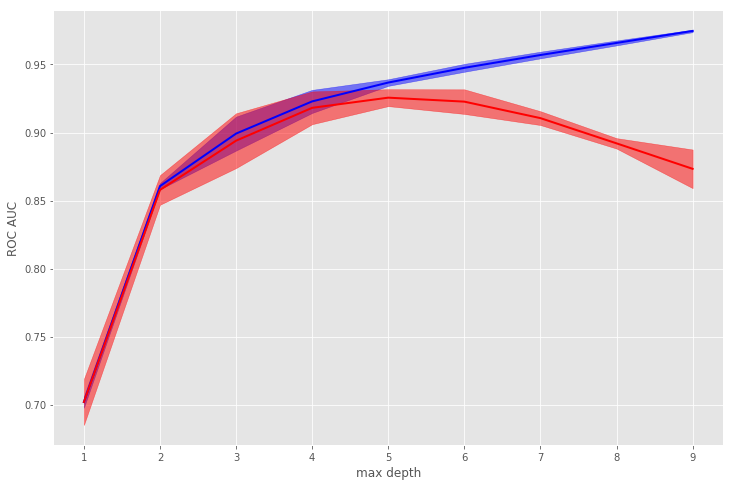

In [185]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

# ---------------------------------------------------------------------
# ищем максимальную точность на графике max_depth

model2 = DecisionTreeClassifier(random_state=123)
model2.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)
train_scores, valid_scores = validation_curve(model2, X_train, y_train, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2) #синяя линия обучающая выборка
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2) #красная линяя - валидационная выборка

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку
# ---------------------------------------------------------------------

In [187]:
depth=5 #видно из графика

model2 = DecisionTreeClassifier(max_depth = depth, random_state=123)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.94      0.97      0.95      7230
        1.0       0.68      0.49      0.57       925

avg / total       0.91      0.92      0.91      8155
 



In [190]:
model3_1 = LogisticRegression()                     # инициализируем модель
model3_1.fit(X_train, y_train)                      # обучаем модель
predict = model3_1.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.92      0.97      0.95      7230
        1.0       0.65      0.38      0.48       925

avg / total       0.89      0.91      0.90      8155
 



In [191]:
model3_2 = LogisticRegression(class_weight='balanced')                     # инициализируем модель
model3_2.fit(X_train, y_train)                      # обучаем модель
predict = model3_2.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.98      0.86      0.92      7230
        1.0       0.44      0.89      0.59       925

avg / total       0.92      0.86      0.88      8155
 



In [192]:
model3_2_proba = model3_2.predict_proba(X_test )
roc_auc_score(y, model3_2_proba[:, 1])

0.9364624873836492

In [193]:
model3_1_proba = model3_1.predict_proba(X_test )
roc_auc_score(y, model3_1_proba[:, 1])

0.9309307315614369

(-0.01, 1.01)

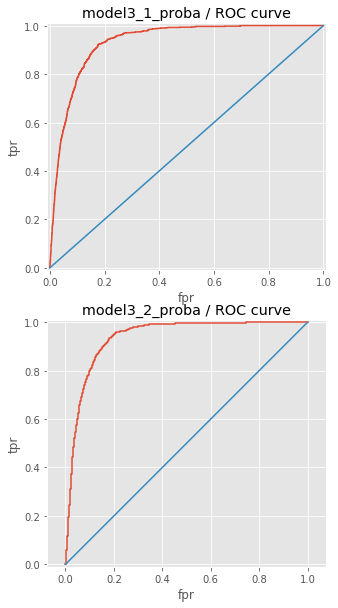

In [194]:
plt.figure(figsize=(5, 10))

#subplot 1
plt.subplot(211)
predict_proba1 = model3_1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('model3_1_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(212)
predict_proba2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('model3_2_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [195]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross3_1 = cross_val_score(model3_1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3_2 = cross_val_score(model3_2,df_x_train,df_y_train,scoring='roc_auc', cv=10)


print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
      '\nmodel3_1. LogisticRegression\t\t\t\t{:.4f}                   \
      \nmodel3_2. LogisticRegression (class_weight=balanced) \t{:.4f}'
      .format( (sum(cross3_1) / float(len(cross3_1))),
              (sum(cross3_2) / float(len(cross3_2))),
             ) )

########## >>> AVG roc_auc for Train: <<< ########## 
model3_1. LogisticRegression				0.9294                         
model3_2. LogisticRegression (class_weight=balanced) 	0.9354


In [196]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'], #критерии
    'max_depth': randint(2, 8), #максимальная глубина от 2 до 8
    'min_samples_leaf': randint(5, 10), #минимальное количество объектов в вершие дерева, достаточное чтоб дробить дерево на части
    'class_weight': [None, 'balanced']} #объекты классов, которые недопредставлены в выборке, будет взвешивать и балансировать

# Некоторые параметры мы задали не простым перечислением значений, а с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model4 = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model4, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123) #200 переборов, n_jobs=-1 дает параллельное вычисление
# А дальше, просто .fit()
random_search.fit(X_train, y_train)
model4best = random_search.best_estimator_

predict = model4best.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier random_search']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier random_search <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier random_search <<< ########## 
              precision    recall  f1-score   support

        0.0       0.99      0.82      0.90      7230
        1.0       0.40      0.92      0.56       925

avg / total       0.92      0.83      0.86      8155
 



In [197]:
model4_proba = random_search.predict_proba(X_test )
roc_auc_score(y, model4_proba[:, 1])

0.9312177488692012

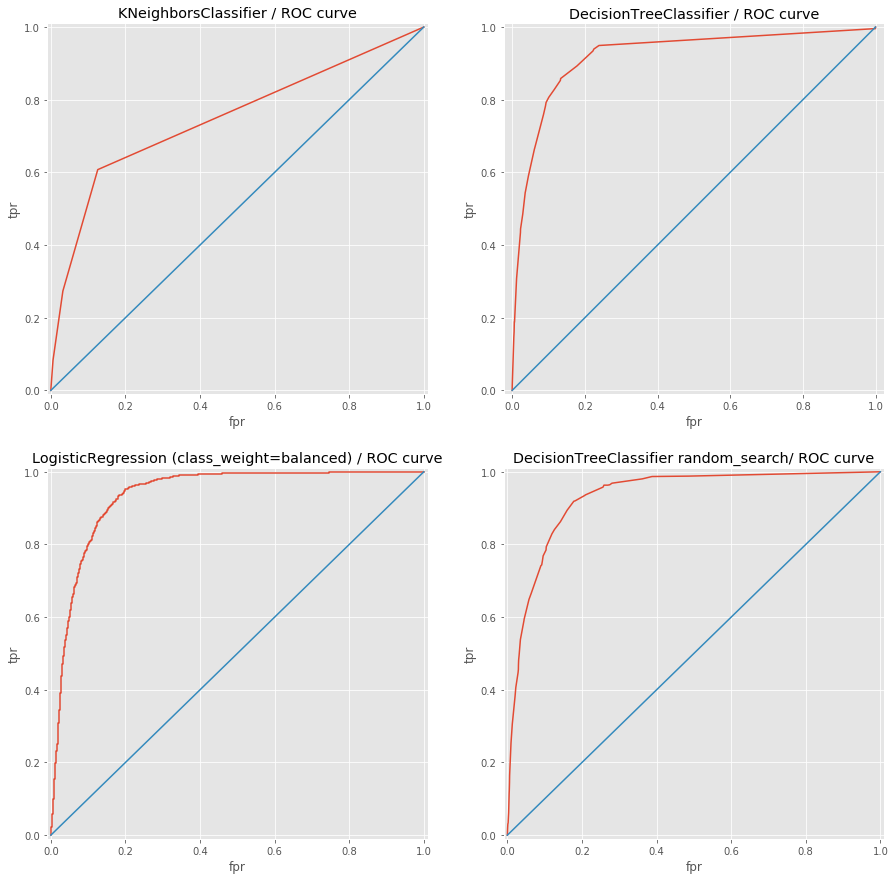

In [198]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

plt.figure(figsize=(15, 15))

#subplot 1
plt.subplot(221)
predict_proba1 = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('KNeighborsClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(222)
predict_proba2 = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 3
plt.subplot(223)
predict_proba3_2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3_2[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression (class_weight=balanced) / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 4
plt.subplot(224)
predict_proba3 = model4best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('DecisionTreeClassifier random_search/ ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [199]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3_2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross4 = cross_val_score(model4best,df_x_train,df_y_train,scoring='roc_auc', cv=10)

print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
      '\nModel 1. KNeighborsClassifier\t\t\t{:.4f}                   \
      \nModel 2. DecisionTreeClassifier\t\t\t{:.4f}                  \
      \nModel 3. LogisticRegression (class_weight=balanced) \t{:.4f}                      \
      \nModel 4. DecisionTreeClassifier random_search\t{:.4f} '
      .format( (sum(cross1) / float(len(cross1))),
              (sum(cross2) / float(len(cross2))),
              (sum(cross3) / float(len(cross3))),
              (sum(cross4) / float(len(cross4))),
             ) )

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. KNeighborsClassifier			0.7676                         
Model 2. DecisionTreeClassifier			0.9273                        
Model 3. LogisticRegression (class_weight=balanced) 	0.9354                            
Model 4. DecisionTreeClassifier random_search	0.9373 


In [201]:
predict = model4best.predict(df_x_test)
df_test_preproc['target'] = predict
df_test_preproc['target'] = df_test_preproc['target'].astype('int')
print(list(df_test_preproc.columns))

['_id', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays', 'previous', 'target', '0.0_x', '1.0_x', 'age_bin_conversion', '0.0_y', '1.0_y', 'job_conversion', '0.0_x', '1.0_x', 'marital_conversion', '0.0_y', '1.0_y', 'education_conversion', '0.0_x', '1.0_x', 'contact_conversion', '0.0_y', '1.0_y', 'month_conversion', 0.0, 1.0, 'day_of_week_conversion', 'age_bin_[10, 30)', 'age_bin_[30, 40)', 'age_bin_[40, 50)', 'age_bin_[50, 60)', 'age_bin_[60, 100)', 'is_contact', 'is_success', 'contact_cellular', 'contact_telephone', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'housing_no', 'housing_unknown', 'housing_yes', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'jo

In [202]:
df_result = df_test_preproc[['_id','target']]

In [203]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int64
dtypes: int64(1), object(1)
memory usage: 386.2+ KB


In [206]:
df_result.to_csv('result_submission.csv', sep=',', encoding='utf-8',index=False)